In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class FNN(object):
    """Build a general FeedForward neural network
    Parameters
    ----------
    learning_rate : float
    drop_out : float
    Layers : list
        The number of layers
    N_hidden : list
        The numbers of nodes in layers
    D_input : int
        Input dimension
    D_label : int
        Label dimension
    Task_type : string
        'regression' or 'classification'
    L2_lambda : float
    Auther : YJango; 2016/11/25
    """
    def __init__(self, learning_rate, drop_keep, Layers, N_hidden, D_input, D_label, Task_type='regression', L2_lambda=0.0):
        
        #var
        self.learning_rate = learning_rate
        self.drop_keep = np.array(drop_keep).astype(np.float32)
        self.Layers = Layers
        self.N_hidden = N_hidden
        self.D_input = D_input
        self.D_label = D_label
        # 类型控制loss函数的选择
        self.Task_type = Task_type
        # l2 regularization的惩罚强弱，过高会使得输出都拉向0
        self.L2_lambda = L2_lambda
        # 用于存放所累积的每层l2 regularization
        self.l2_penalty = tf.constant(0.0)
        
        # 用于生成tensorflow缩放图的,括号里起名字
        with tf.name_scope('Input'):
            self.inputs = tf.placeholder(tf.float32, [None, D_input], name="inputs")
        with tf.name_scope('Label'):
            self.labels = tf.placeholder(tf.float32, [None, D_label], name="labels")
        with tf.name_scope('keep_rate'):
            self.drop_keep_rate = tf.placeholder(tf.float32, name="dropout_keep")
        

        # 初始化的时候直接生成，build方法是后面会建立的
        self.build('F')
        
    def weight_init(self,shape):
        # shape : list [in_dim, out_dim]
        # can change initialization here
        initial = tf.truncated_normal(shape, stddev=0.1)/tf.sqrt(np.array(shape[1],dtype=tf.float32))
        return tf.Variable(initial)

    def bias_init(self,shape):
        # can change initialization here
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)
    
    def variable_summaries(self, var, name):
        with tf.name_scope(name+'_summaries'):
            mean = tf.reduce_mean(var)
            tf.scalar_summary('mean/' + name, mean)
        with tf.name_scope(name+'_stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        # 记录每次训练后变量的数值变化
        tf.scalar_summary('_stddev/' + name, stddev)
        tf.scalar_summary('_max/' + name, tf.reduce_max(var))
        tf.scalar_summary('_min/' + name, tf.reduce_min(var))
        tf.histogram_summary(name, var)

    def layer(self,in_tensor, in_dim, out_dim, layer_name, act=tf.nn.relu):
        with tf.name_scope(layer_name):
            with tf.name_scope(layer_name+'_weights'):
                # 用所建立的weight_init函数进行初始化。
                weights = self.weight_init([in_dim, out_dim])
                # 存放着每一个权重W
                self.W.append(weights)
                # 对权重进行统计
                self.variable_summaries(weights, layer_name + '/weights')
            with tf.name_scope(layer_name+'_biases'):
                biases = self.bias_init([out_dim])
                # 存放着每一个偏移b
                self.b.append(biases)
                self.variable_summaries(biases, layer_name + '/biases')
            with tf.name_scope(layer_name+'_Wx_plus_b'):
                # 计算Wx+b
                pre_activate = tf.matmul(in_tensor, weights) + biases
                # 记录直方图
                tf.histogram_summary(layer_name + '/pre_activations', pre_activate)
            # 计算a(Wx+b)
            activations = act(pre_activate, name='activation')
            tf.histogram_summary(layer_name + '/activations', activations)
        # 最终返回该层的输出，以及权重W的L2
        return activations, tf.nn.l2_loss(weights)

    def drop_layer(self,in_tensor):
            #tf.scalar_summary('dropout_keep', self.drop_keep_rate)
        dropped = tf.nn.dropout(in_tensor, self.drop_keep_rate)
        return dropped

    def build(self, prefix):
        # 建立网络 
        # incoming也代表当前tensor的流动位置
        incoming = self.inputs
        # 如果没有隐藏层
        if self.Layers!=0:
            layer_nodes = [self.D_input] + self.N_hidden
        else:
            layer_nodes = [self.D_input]
        
        # hid_layers用于存储所有隐藏层的输出
        self.hid_layers=[]
        # W用于存储所有层的权重
        self.W=[]
        # b用于存储所有层的偏移
        self.b=[]
        # total_l2用于存储所有层的L2
        self.total_l2=[]
        
        # 开始叠加隐藏层。这跟千层饼没什么区别。
        for l in range(self.Layers):
            # 使用刚才编写的函数来建立层，并更新incoming的位置
            incoming,l2_loss= self.layer(incoming,layer_nodes[l],layer_nodes[l+1],prefix+'_hid_'+str(l+1),act=tf.nn.relu)
            # 累计l2
            self.total_l2.append(l2_loss)
            # 输出一些信息，让我们知道网络在建造中做了什么
            print('Add dense layer: relu with drop_keep:%s' %self.drop_keep)
            print('    %sD --> %sD' %(layer_nodes[l],layer_nodes[l+1]))
            # 存储所有隐藏层的输出
            self.hid_layers.append(incoming)
            # 加入dropout层
            incoming = self.drop_layer(incoming)
            
        # 输出层的建立。输出层需要特别对待的原因是输出层的activation function要根据任务来变。
        # 回归任务的话，下面用的是tf.identity，也就是没有activation function
        if self.Task_type=='regression':
            out_act=tf.identity
        else:
            # 分类任务使用softmax来拟合概率
            out_act=tf.nn.softmax
        self.output,l2_loss= self.layer(incoming,layer_nodes[-1],self.D_label, layer_name='output',act=out_act)
        print('Add output layer: linear')
        print('    %sD --> %sD' %(layer_nodes[-1],self.D_label))
        
        # l2 loss的缩放图
        with tf.name_scope('total_l2'):
            for l2 in self.total_l2:
                self.l2_penalty+=l2
            tf.scalar_summary('l2_penalty', self.l2_penalty)
            
        # 不同任务的loss
        # 若为回归，则loss是用于判断所有预测值和实际值差别的函数。
        if self.Task_type=='regression':
            with tf.name_scope('SSE'):
                self.loss=tf.reduce_mean((self.output-self.labels)**2)
                tf.scalar_summary('loss', self.loss)
        else:
            # 若为分类，cross entropy的loss function
            entropy = tf.nn.softmax_cross_entropy_with_logits(self.output, self.labels)
            with tf.name_scope('cross_entropy'):
                self.loss = tf.reduce_mean(entropy)
                tf.scalar_summary('loss', self.loss)
            with tf.name_scope('accuracy'):
                correct_prediction = tf.equal(tf.argmax(self.output, 1), tf.argmax(self.labels, 1))
                self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
                tf.scalar_summary('accuracy', self.accuracy)
                
        # 整合所有loss，形成最终loss
        with tf.name_scope('total_loss'):
            self.total_loss=self.loss + self.l2_penalty*self.L2_lambda
            tf.scalar_summary('total_loss', self.total_loss)
            
        # 训练操作
        with tf.name_scope('train'):
            self.train_step = tf.train.AdamOptimizer(self.learning_rate).minimize(self.total_loss)

        # 洗牌功能
    def shufflelists(self,lists):
        ri=np.random.permutation(len(lists[1]))
        out=[]
        for l in lists:
            out.append(l[ri])
        return out

In [3]:
# 准备训练数据
inputs=[[0,0],[0,1],[1,0],[1,1]]
outputs=[0,1,1,0]
X=np.array(inputs).reshape((4,1,2)).astype('int16')
Y=np.array(outputs).reshape((4,1,1)).astype('int16')

In [4]:
# 生成网络实例
ff=FNN(learning_rate=1e-3, drop_keep=1.0, Layers=1, N_hidden=[2], D_input=2, D_label=1, Task_type='regression', L2_lambda=1e-2)

here
Add dense layer: relu with drop_keep:1.0
    2D --> 2D
Add output layer: linear
    2D --> 1D


In [5]:
# 加载
sess = tf.InteractiveSession()
tf.initialize_all_variables().run()
merged = tf.merge_all_summaries()
train_writer = tf.train.SummaryWriter('log' + '/train',sess.graph)

In [10]:
# 训练并记录
k=0.0
for i in range(10000):
    k+=1
    summary, _ = sess.run([merged,ff.train_step],feed_dict={ff.inputs:X.reshape((4,2)),ff.labels:Y.reshape((4,1)),ff.drop_keep_rate:1.0})
    train_writer.add_summary(summary, k)

W_0:
[[-0.17334478 -0.0750991 ]
 [-0.02134527  0.03925243]]
W_1:
[[ 0.00257381]
 [ 0.0365728 ]]


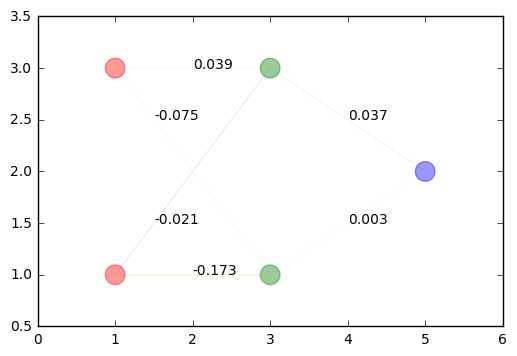

In [7]:
# 训练前的权重


W0=sess.run(ff.W[0])
W1=sess.run(ff.W[1])
print('W_0:\n%s' %sess.run(ff.W[0]))
print('W_1:\n%s' %sess.run(ff.W[1]))

plt.scatter([1,1,5],[1,3,2],color=['red','red','blue'],s=200,alpha=0.4,marker='o')
plt.scatter([3,3],[1,3],color=['green','green'],s=200,alpha=0.4,marker='o')

plt.plot([1,3],[1,1],color='orange',linewidth=abs(W0[0,0]))
plt.annotate(str(round(W0[0,0],3)),xy=(2, 1.0))

plt.plot([1,3],[3,1],color='blue',linewidth=abs(W0[1,0]))
plt.annotate(str(round(W0[1,0],3)),xy=(1.5, 1.5))

plt.plot([1,3],[1,3],color='blue',linewidth=abs(W0[0,1]))
plt.annotate(str(round(W0[0,1],3)),xy=(1.5, 2.5))

plt.plot([1,3],[3,3],color='orange',linewidth=abs(W0[1,1]))
plt.annotate(str(round(W0[1,1],3)),xy=(2, 3))

plt.plot([3,5],[1,2],color='blue',linewidth=abs(W1[0]))
plt.annotate(str(round(W1[0],3)),xy=(4, 1.5))

plt.plot([3,5],[3,2],color='blue',linewidth=abs(W1[1]))
plt.annotate(str(round(W1[1],3)),xy=(4, 2.5))

W_0:
[[-0.82895017  0.82891428]
 [ 0.82915729 -0.82918972]]
W_1:
[[ 1.17231631]
 [ 1.1722393 ]]


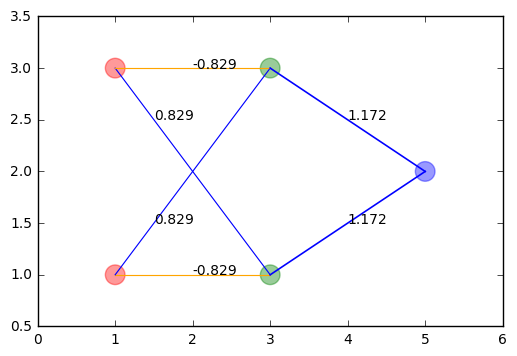

In [11]:
# 训练后的权重

W0=sess.run(ff.W[0])
W1=sess.run(ff.W[1])
print('W_0:\n%s' %sess.run(ff.W[0]))
print('W_1:\n%s' %sess.run(ff.W[1]))

plt.scatter([1,1,5],[1,3,2],color=['red','red','blue'],s=200,alpha=0.4,marker='o')
plt.scatter([3,3],[1,3],color=['green','green'],s=200,alpha=0.4,marker='o')

plt.plot([1,3],[1,1],color='orange',linewidth=abs(W0[0,0]))
plt.annotate(str(round(W0[0,0],3)),xy=(2, 1.0))

plt.plot([1,3],[3,1],color='blue',linewidth=abs(W0[1,0]))
plt.annotate(str(round(W0[1,0],3)),xy=(1.5, 1.5))

plt.plot([1,3],[1,3],color='blue',linewidth=abs(W0[0,1]))
plt.annotate(str(round(W0[0,1],3)),xy=(1.5, 2.5))

plt.plot([1,3],[3,3],color='orange',linewidth=abs(W0[1,1]))
plt.annotate(str(round(W0[1,1],3)),xy=(2, 3))

plt.plot([3,5],[1,2],color='blue',linewidth=abs(W1[0]))
plt.annotate(str(round(W1[0],3)),xy=(4, 1.5))

plt.plot([3,5],[3,2],color='blue',linewidth=abs(W1[1]))
plt.annotate(str(round(W1[1],3)),xy=(4, 2.5))

[[ 0.10391466]
 [ 0.10529529]
 [ 0.1009107 ]
 [ 0.10234627]]


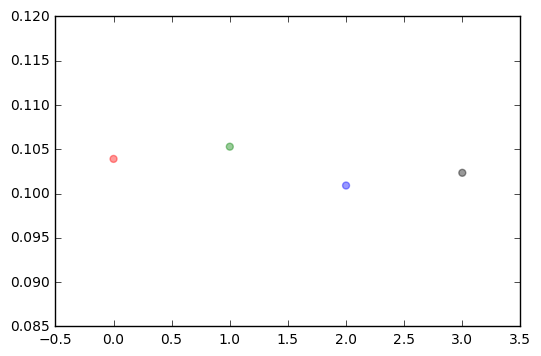

In [8]:
# 训练前的输出
pY=sess.run(ff.output,feed_dict={ff.inputs:X.reshape((4,2)),ff.drop_keep_rate:1.0})
print(pY)
plt.scatter([0,1,2,3],pY,color=['red','green','blue','black'],s=25,alpha=0.4,marker='o')

[[  0.00000000e+00]
 [  9.72034633e-01]
 [  9.71685886e-01]
 [  2.42817347e-04]]


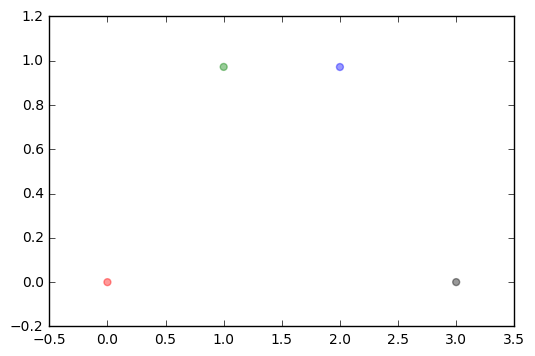

In [8]:
# 训练后的输出
pY=sess.run(ff.output,feed_dict={ff.inputs:X.reshape((4,2)),ff.drop_keep_rate:1.0})
print(pY)
plt.scatter([0,1,2,3],pY,color=['red','green','blue','black'],s=25,alpha=0.4,marker='o')

[[ 0.1         0.1       ]
 [ 0.07865474  0.13925242]
 [ 0.          0.02490091]
 [ 0.          0.06415333]]


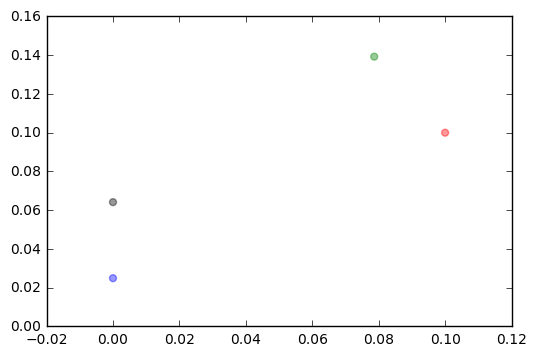

In [9]:
# 训练前隐藏层的输出
pY=sess.run(ff.hid_layers[0],feed_dict={ff.inputs:X.reshape((4,2)),ff.drop_keep_rate:1.0})
print(pY)
plt.scatter(pY[:,0],pY[:,1],color=['red','green','blue','black'],s=25,alpha=0.4,marker='o')

[[  0.00000000e+00   0.00000000e+00]
 [  8.29157293e-01   0.00000000e+00]
 [  0.00000000e+00   8.28914285e-01]
 [  2.07126141e-04   0.00000000e+00]]


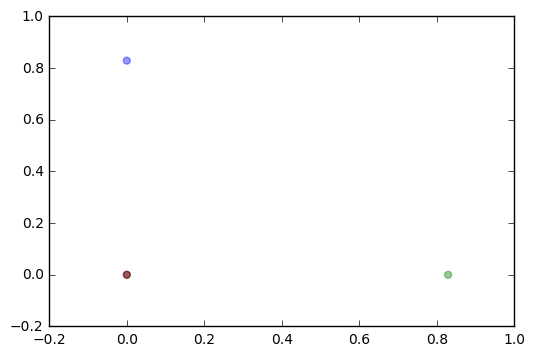

In [7]:
# 训练后隐藏层的输出
pY=sess.run(ff.hid_layers[0],feed_dict={ff.inputs:X.reshape((4,2)),ff.drop_keep_rate:1.0})

print(pY)
plt.scatter(pY[:,0],pY[:,1],color=['red','green','blue','black'],s=25,alpha=0.4,marker='o')

In [ ]:
# 该操作可以用于读取已经训练好的权重W和b
# 每层W想要读取的值
W_0=np.array([[-0.82895017,0.82891428],[ 0.82915729,-0.82918972]],dtype='float32')
W_1=np.array([[ 1.17231631],[ 1.1722393 ]],dtype='float32')
# 每层b想要读取的值
b_0=np.array([0,0],dtype='float32')
b_1=np.array([0],dtype='float32')
# 读取ops
reload1=tf.assign(ff.W[0],W_0)
reload2=tf.assign(ff.W[1],W_1)
reload3=tf.assign(ff.b[0],b_0)
reload4=tf.assign(ff.b[1],b_1)
# 执行ops
sess.run([reload1,reload2,reload3,reload4])